In [1]:
import os
from os.path import join as oj
import sys, time
sys.path.insert(1, oj(sys.path[0], '..'))  # insert parent path
sys.path.insert(1, oj(sys.path[0], '..', 'vision_fit'))  # insert parent path
sys.path.insert(1, oj(sys.path[0], '..', 'vision_analyze'))  # insert parent path

import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm
from copy import deepcopy
import pickle as pkl
import pandas as pd
import math
# plt.style.use('dark_background')
from collections import OrderedDict
from sklearn import preprocessing

import torch
from torch.autograd import Variable
# from mog_analyze import viz
from sklearn.decomposition import PCA

import warnings
warnings.filterwarnings("ignore")

from vision_fit import data
import viz_weights
from process_results import process_results

%matplotlib inline
%load_ext autoreload
%autoreload 2

import style
cb = '#008fd5'
cr = '#fc4f30'

In [2]:
style.set_style()

# load results from a directory

In [3]:
# depending on how much is saved, this may take a while
out_dir = '/scratch/users/vision/yu_dl/raaz.rsk/track_acts/resweep_full_new'
# out_dir2 = '/scratch/users/vision/yu_dl/raaz.rsk/track_acts/resweep_full_new2'
fnames = sorted([oj(out_dir, fname) for fname in os.listdir(out_dir)[:100] \
                 if not fname.startswith('weights') \
                 and not fname.startswith('idx')]) #+ \
#          sorted([oj(out_dir2, fname) for fname in os.listdir(out_dir2) \
#                  if not fname.startswith('weights') \
#                  and not fname.startswith('idx')])    
results_list = [pd.Series(pkl.load(open(fname, "rb"))) for fname in tqdm(fnames) 
                if not fname.startswith('weights') and not fname.startswith('idx')]
results = pd.concat(results_list, axis=1).T.infer_objects()
print(results.shape)

100%|██████████| 35/35 [00:02<00:00, 14.13it/s]

(35, 54)


**add cols**

In [4]:
# adds these vec keys: fc0_fro, fc1_fro, fc0_stab_rank, fc1_stab_rank, act0_stab_rank, act1_stab_rank, corr0, corr1
# adds these scalar keys: max_train_acc, max_test_acc, _final of all the above
# print('before', results.shape)
its, ts, results = process_results(results)
print('after', results.shape)

after (32, 86)


# pick examples

In [76]:
results = results.sort_values('max_test_acc', ascending=False)
pid = results.pid.iloc[0]

In [77]:
out_dir = '/scratch/users/vision/yu_dl/raaz.rsk/track_acts/resweep_full_new'
out_dir2 = '/scratch/users/vision/yu_dl/raaz.rsk/track_acts/resweep_full_new2'
fnames = sorted([oj(out_dir, fname) for fname in os.listdir(out_dir) \
                 if pid in fname])

# weights
fnames_w = [fname for fname in fnames if 'weights' in fname]
results_list = [pd.Series(pkl.load(open(fname, "rb"))) for fname in fnames_w]
rw = pd.concat(results_list, axis=1).T.infer_objects()

# normal results
fnames_acc = [fname for fname in fnames if '/pid' in fname] # normal results
results_list = [pd.Series(pkl.load(open(fname, "rb"))) for fname in fnames_acc]
r = pd.concat(results_list, axis=1).T.infer_objects()
its, ts, r = process_results(r)

# get individual weights
row_w = rw[rw.optimizer == 'sgd'].reset_index().iloc[0]

# get accs
row_accs = r[r.optimizer == 'sgd'].reset_index().iloc[0]

row = pd.concat([row_w, row_accs])

# analyze the row

In [78]:
list(row.keys())

['index',
 'freeze',
 'shuffle_labels',
 'dset',
 'num_layers',
 'optimizer',
 'batch_size',
 'seed',
 'lr',
 'weights',
 'save_acts_and_reduce',
 'pid',
 'lr_step',
 'weights_first10',
 'saves_per_iter_end',
 'use_conv_special',
 'save_all_weights_freq',
 'calc_activations',
 'its',
 'out_dir',
 'lr_ticks',
 'hidden_size',
 'num_iters_small',
 'saves_per_iter',
 'use_conv',
 'num_iters',
 'index',
 'freeze',
 'shuffle_labels',
 'num_layers',
 'optimizer',
 'lr',
 'mean_margin_test',
 'mean_margin_train_unnormalized',
 'lr_ticks',
 'lr_step',
 'singular_val_dicts_rbf',
 'singular_val_dicts_cosine',
 'accs_test',
 'mean_max_corrs',
 'its',
 'act_singular_val_dicts_test_rbf',
 'mean_margin_test_unnormalized',
 'accs_train',
 'weight_names',
 'num_iters_small',
 'saves_per_iter',
 'use_conv',
 'num_iters',
 'singular_val_dicts_lap',
 'act_singular_val_dicts_train_rbf',
 'dset',
 'batch_size',
 'seed',
 'act_singular_val_dicts_train_pca',
 'accs_train_r',
 'save_acts_and_reduce',
 'pid',
 

In [79]:
lay = 'fc.0.weight'
epoch = 0

# keys are epochs, vals are dicts of all weights
weights_dict_dict = row['weights']

In [80]:
epochs = sorted(weights_dict_dict.keys())

# keys are layers, vals are weight values
#     print(weights_dict_dict.keys())
weights_dict = weights_dict_dict[epoch]
#     print(weights_dict.keys())

w = weights_dict[lay]

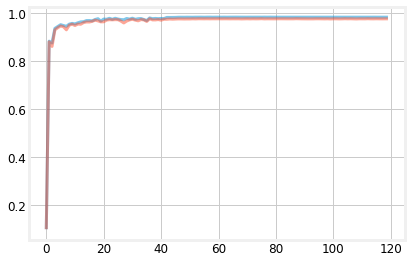

In [81]:
plt.plot(row.accs_test)


In [104]:
def calc_dim(svals, percent_to_explain = 0.9):
    svals_squared = np.square(svals)
    denom = np.sum(svals_squared)
    perc_explained = 0
    dim = 0
    while perc_explained <= percent_to_explain:
        perc_explained += svals_squared[dim] / denom
        dim += 1
    return dim
svals_list = [d[lay] for d in row['singular_val_dicts_pca']]
dims = [calc_dim(svals) for svals in svals_list]
svals_list2 = [d['fc.1.weight'] for d in row['singular_val_dicts_pca']]
dims2 = [calc_dim(svals) for svals in svals_list2]

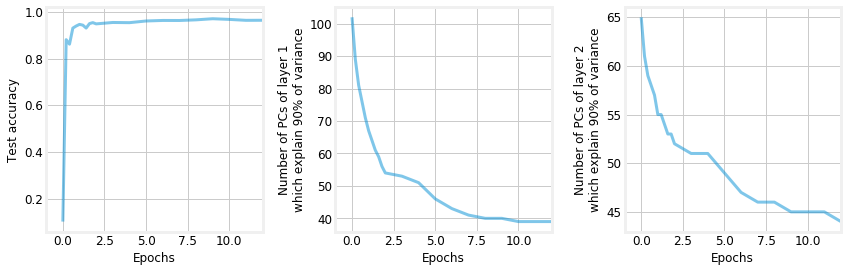

In [109]:
plt.figure(figsize=(12, 4))
R, C = 1, 3
plt.subplot(R, C, 1)
plt.ylabel('Test accuracy')
plt.plot(its, row.accs_test_r)
plt.xlim((-1, 12))
plt.xlabel('Epochs')


plt.subplot(R, C, 2)
plt.plot(its, dims)
plt.ylabel('Number of PCs of layer 1\nwhich explain 90% of variance')
plt.xlim((-1, 12))
plt.xlabel('Epochs')

plt.subplot(R, C, 3)
plt.plot(its, dims2)
plt.ylabel('Number of PCs of layer 2\nwhich explain 90% of variance')
plt.xlim((-1, 12))
plt.xlabel('Epochs')

plt.tight_layout()
plt.savefig('pcs.pdf')
